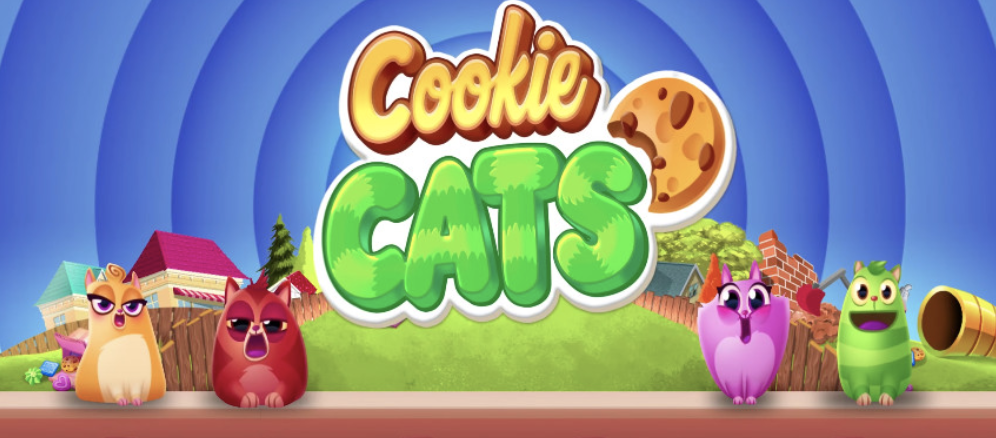

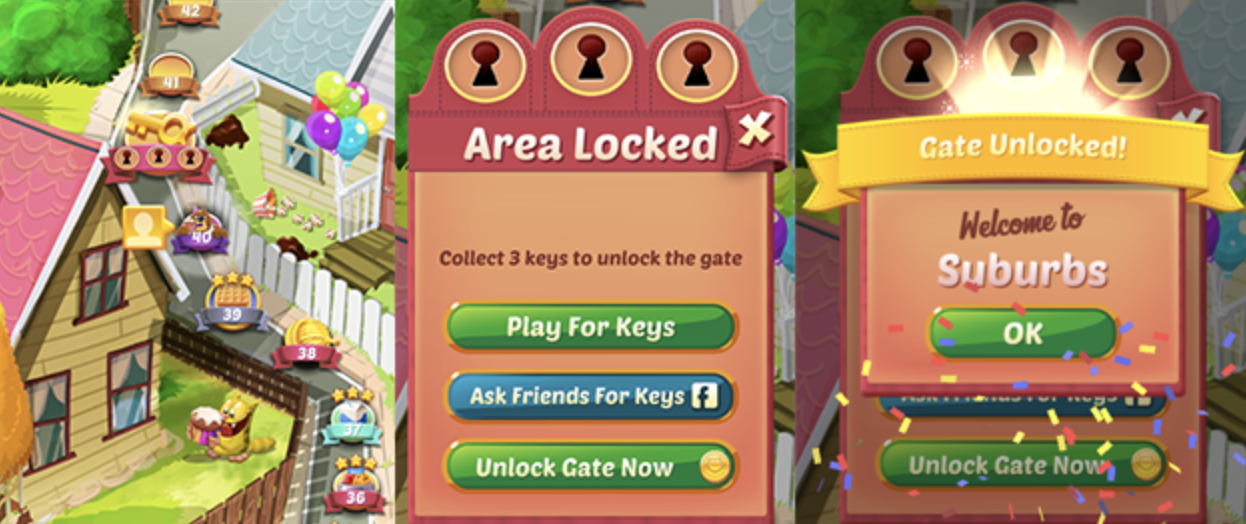

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

**About the data**


---


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:


---



*   userid - a unique number that identifies each player.

*   version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).


*   sum_gamerounds - the number of game rounds played by the player during the first week after installation

*   retention_1 - did the player come back and play 1 day after installing?



*   retention_7 - did the player come back and play 7 days after installing?



When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

# Loading Dataset

In [148]:
!gdown 1N6Nfj7HtA49MRK4EKS0n58MW96v2KCod

Downloading...
From: https://drive.google.com/uc?id=1N6Nfj7HtA49MRK4EKS0n58MW96v2KCod
To: /content/cookie_cats.csv
100% 2.80M/2.80M [00:00<00:00, 93.3MB/s]


In [149]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import shapiro, ttest_ind, shapiro, mannwhitneyu, levene

In [150]:
df = pd.read_csv('cookie_cats.csv')
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


#EDA

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [152]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

**No null values**

In [153]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [154]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

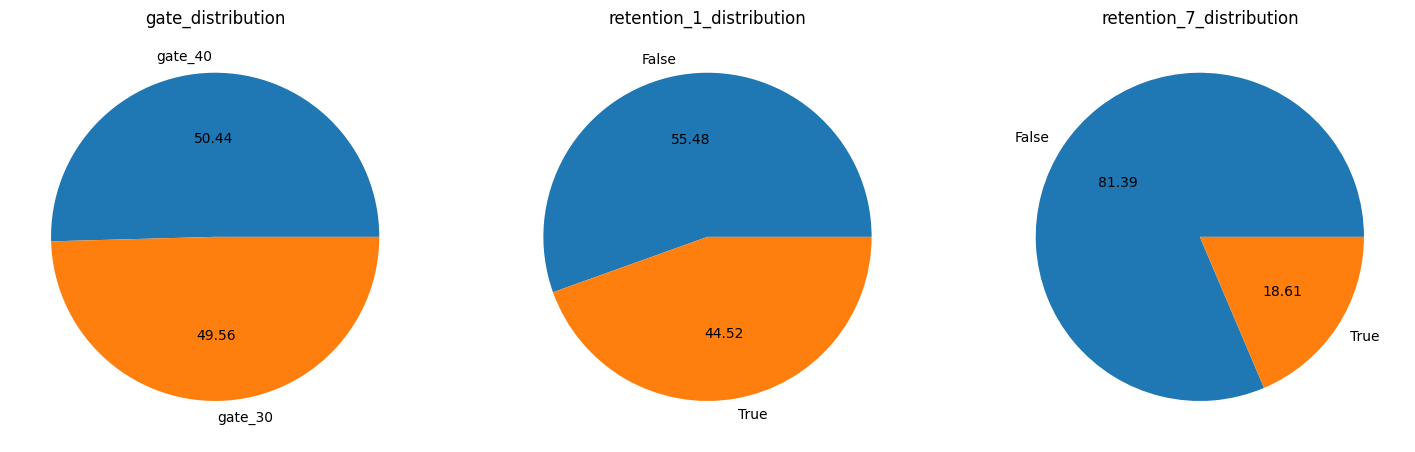

In [155]:
plt.figure(figsize=(18,8))

plt.subplot(1,3,1)
gate_distribution = df['version'].value_counts(normalize=True)*100
plt.pie(x = gate_distribution, labels = gate_distribution.index,autopct = '%.2f')
plt.title('gate_distribution')

plt.subplot(1,3,2)
retention_1_distribution = df['retention_1'].value_counts(normalize=True)*100
plt.pie(x = retention_1_distribution, labels = retention_1_distribution.index,autopct = '%.2f')
plt.title('retention_1_distribution')


plt.subplot(1,3,3)
retention_7_distribution = df['retention_7'].value_counts(normalize=True)*100
plt.pie(x = retention_7_distribution, labels = retention_7_distribution.index,autopct = '%.2f')
plt.title('retention_7_distribution')

plt.show()



In [156]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


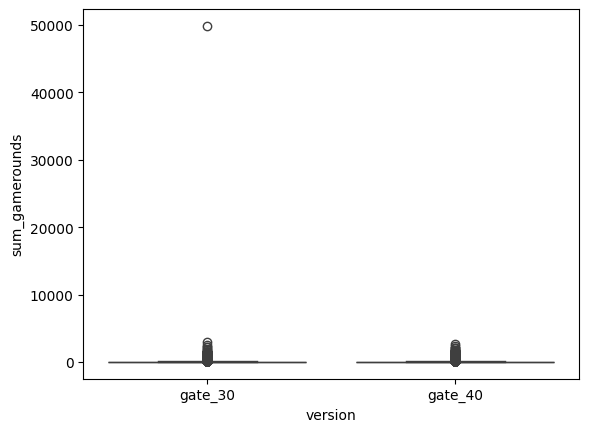

In [157]:
sns.boxplot(x = 'version', y = 'sum_gamerounds', data = df)
plt.show()

**We aren't able to visualise distribution of the data though this box plot (may be due to an outlier)**

**So, let's plot a line graph that represents the number of games played for each user**

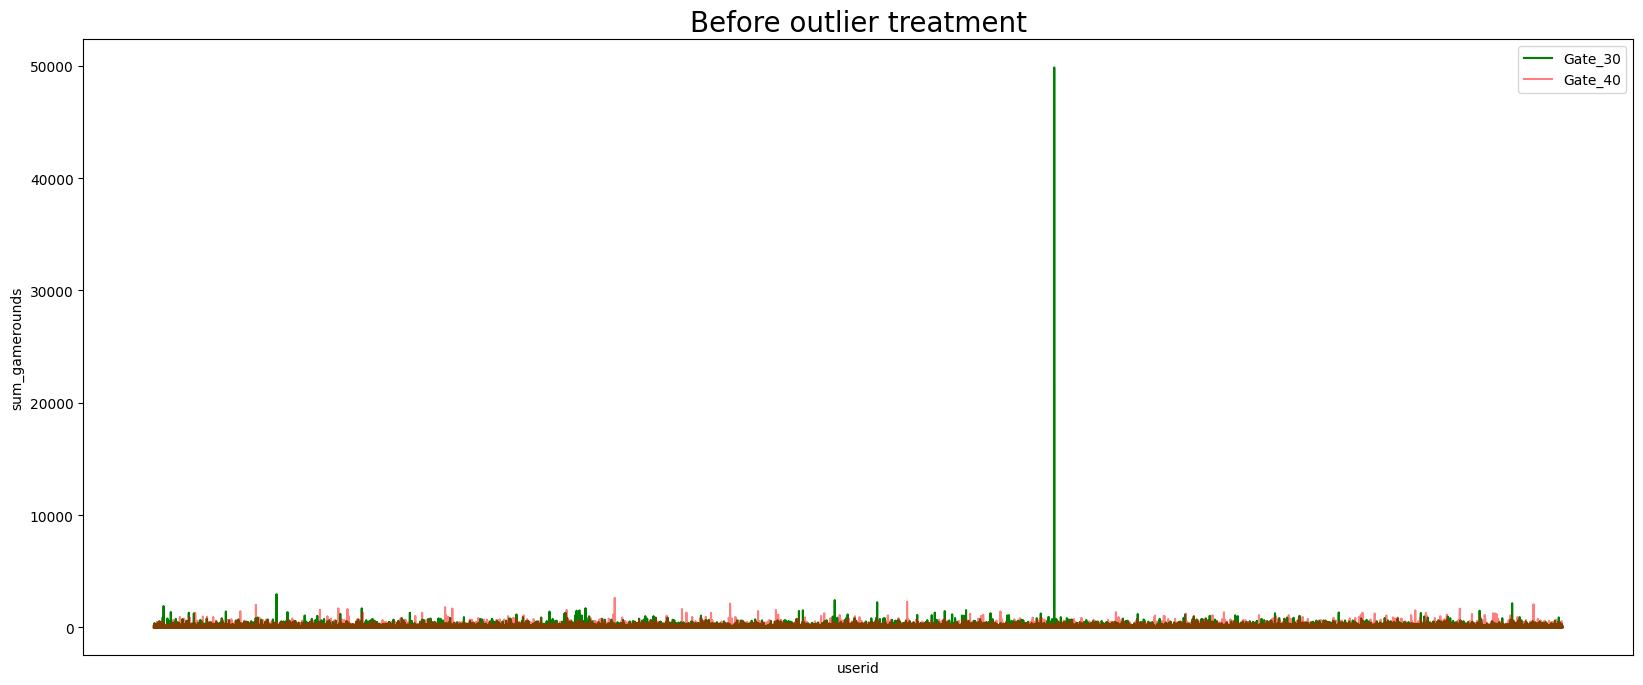

In [158]:
plt.figure(figsize=(20,8))
sns.lineplot(x='userid', y = 'sum_gamerounds', data = df[df['version']=='gate_30'], color='green', label='Gate_30')
sns.lineplot(x='userid', y = 'sum_gamerounds', data = df[df['version']=='gate_40'], color='red', alpha=0.5, label='Gate_40')
plt.title('Before outlier treatment', fontsize=20)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.legend()
plt.show()

#Outlier Treatment

In [159]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

**We observe that max value is too much greater than mean, median and 75th percentile. So, to understand the distribution meaningfully, we shall plot a histogram only for users who have played number of games upto the standard mark of 1.5 time the 75th percentile.**

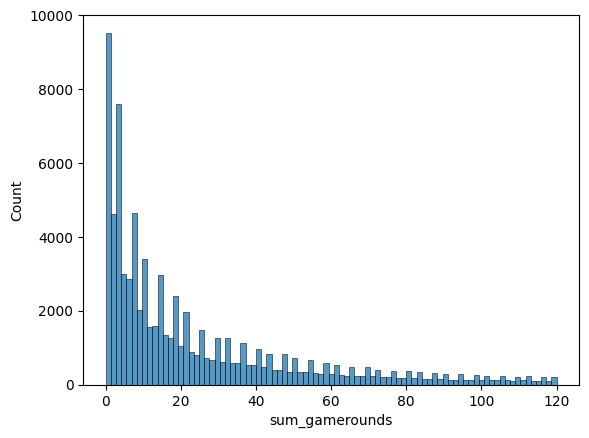

In [160]:
IQR = df['sum_gamerounds'].describe()['75%'] - df['sum_gamerounds'].describe()['25%']
sns.histplot(df['sum_gamerounds'], binrange=(df['sum_gamerounds'].describe()['min'], df['sum_gamerounds'].describe()['75%'] + IQR*1.5))
plt.show()

In [161]:
df[df['sum_gamerounds']>3000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


**We can now confirm that there is only 1 outlier.**


---

**Note : Our analysis aims to capture player behavior trends. In this dataset, a single user's game count significantly exceeds the typical range. This data point, representing approximately 50,000 games played (instead of the standard practice of considering more than 1.5 times the 75th percentile as outliers), will be excluded to ensure the analysis reflects trends for the broader player base.**

In [162]:
df.drop(57702, inplace=True)

In [163]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

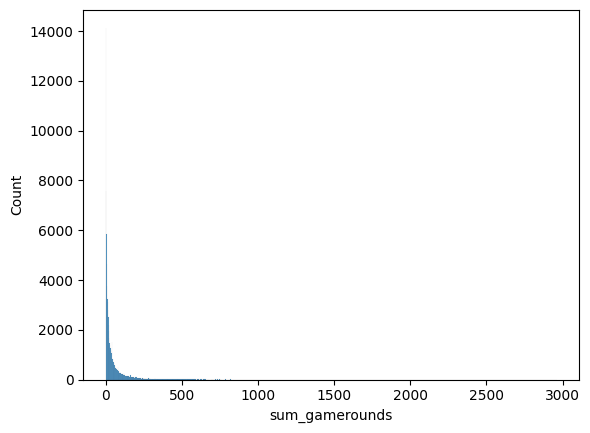

In [164]:
sns.histplot(df['sum_gamerounds'])

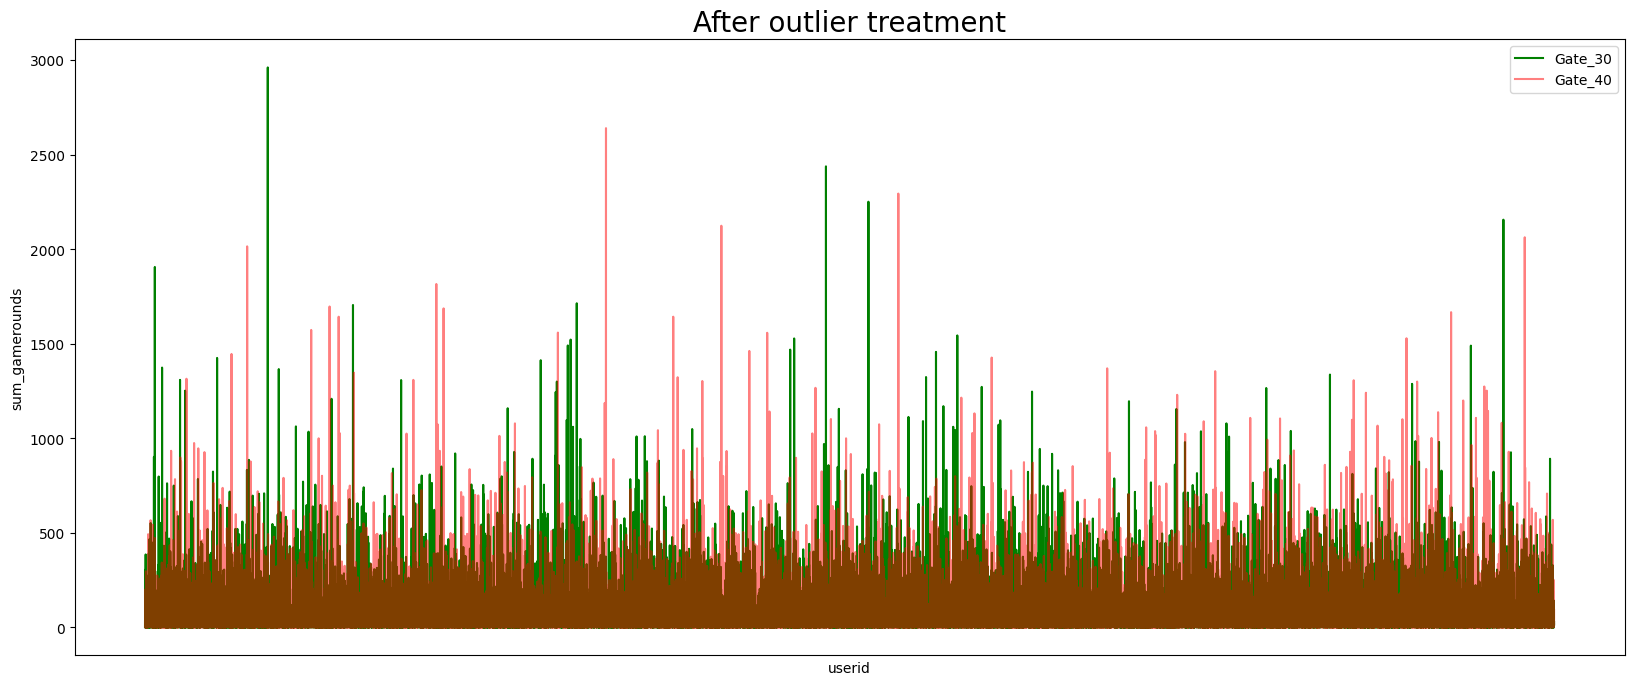

In [165]:
plt.figure(figsize=(20,8))
sns.lineplot(x='userid', y = 'sum_gamerounds', data = df[df['version']=='gate_30'], color='green', label='Gate_30')
sns.lineplot(x='userid', y = 'sum_gamerounds', data = df[df['version']=='gate_40'], color='red', alpha=0.5, label='Gate_40')
plt.title('After outlier treatment', fontsize=20)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.legend()
plt.show()

# Analysis of users

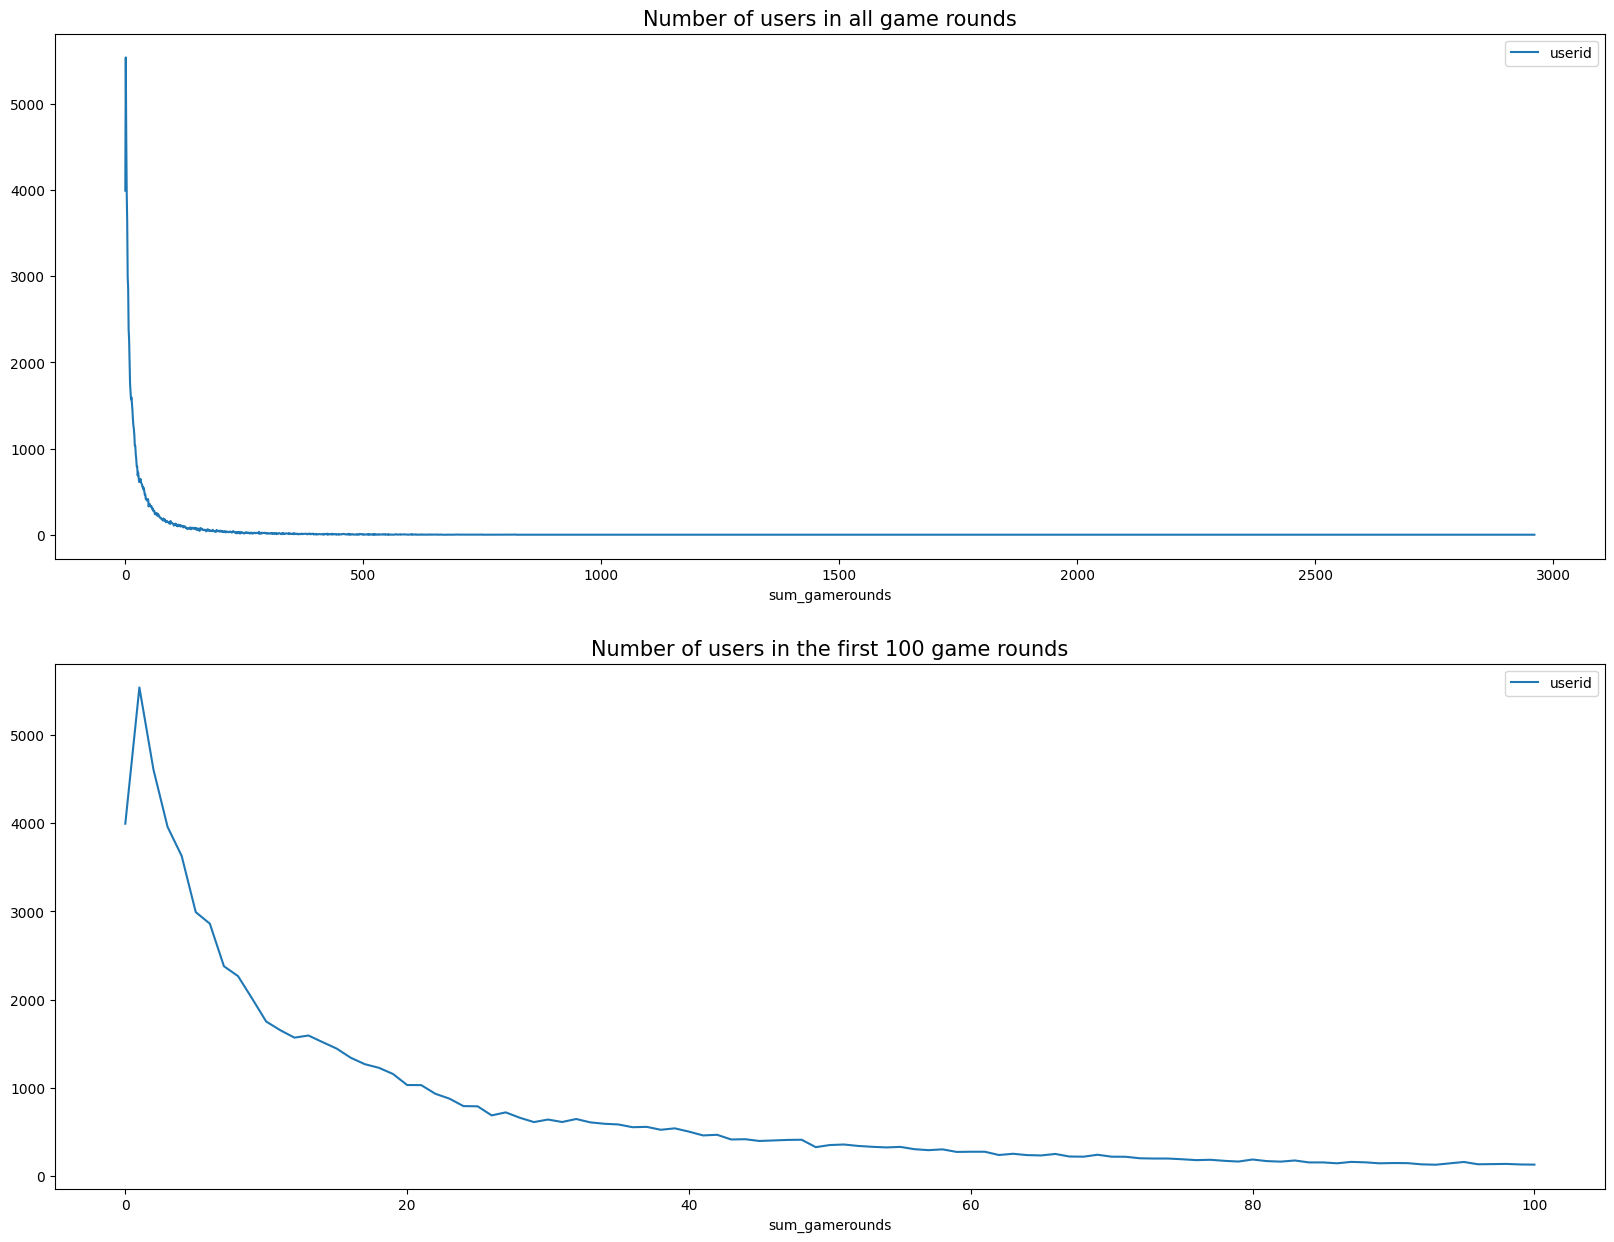

In [166]:
plt.figure(figsize=(20,15))

plt.subplot(2,1,1)
sns.lineplot(df.groupby('sum_gamerounds').aggregate({'userid':'count'}))
plt.title('Number of users in all game rounds', fontsize = 15)


plt.subplot(2,1,2)
sns.lineplot(df.groupby('sum_gamerounds').aggregate({'userid':'count'}).sort_values(by='userid',ascending=False)[:100])
plt.title('Number of users in the first 100 game rounds', fontsize = 15)
plt.show()

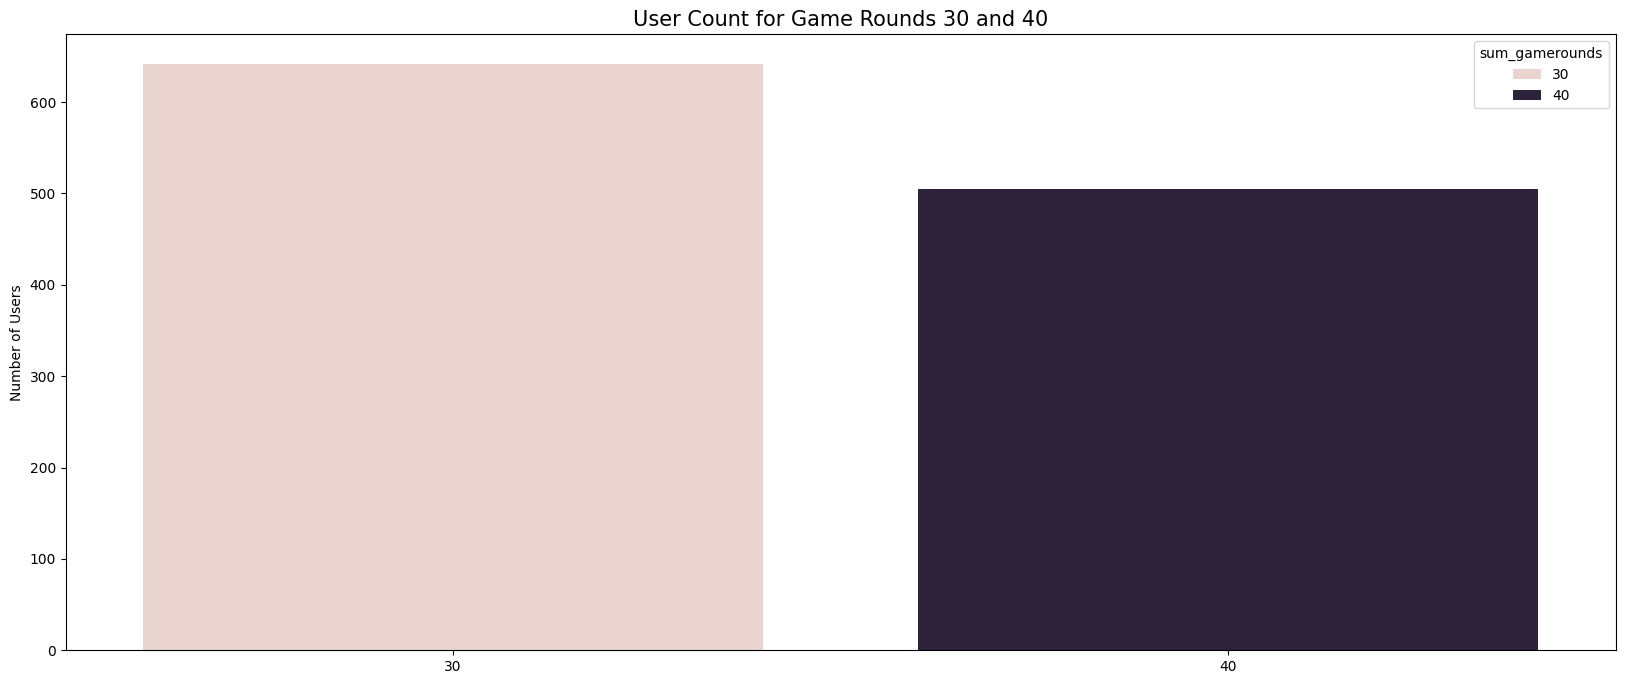

In [167]:
user_counts = df.groupby("sum_gamerounds").aggregate({'userid':'count'}).loc[[30,40]]

plt.figure(figsize=(20,8))

sns.barplot(x=user_counts.index, y='userid', data=user_counts, hue='sum_gamerounds')
plt.title('User Count for Game Rounds 30 and 40', fontsize=15)
plt.xlabel('')
plt.ylabel('Number of Users')
plt.show()


#A/B Test

**Setting up the hypotheses**


---



*   Null Hypothesis (H0) : There is no statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40
*   Alternate Hypothesis (HA) : There is statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40'



##Analysis on 'sum_gamerounds' of all users

In [168]:
df.groupby('version').aggregate({'sum_gamerounds':['count','mean','std','min','max']})

sum_gamerounds                                 
                 count       mean         std min   max
version                                                
gate_30          44699  51.342111  102.057598   0  2961
gate_40          45489  51.298776  103.294416   0  2640

The two groups have approximately the same number of users along with mean and standard deviation.


**Split & Define Control Group & Test Group**


In [169]:
df['retention_1']=np.where(df['retention_1']==True,1,0)
df['retention_7']=np.where(df['retention_7']==True,1,0)
df['version']=np.where(df['version']=='gate_30','A','B')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,0,0
1,337,A,38,1,0
2,377,B,165,1,0
3,483,B,1,0,0
4,488,B,179,1,1


In [170]:
print(f"Number of users who played the game for 1 day : {df['retention_1'].sum()}")
print(f"Number of users who played the game for 7 days : {df['retention_7'].sum()}")

Number of users who played the game for 1 day : 40153
Number of users who played the game for 7 days : 16780


##Selection of appropriate test:


---


**Check normality and Homogenity**
Check for Normal Distribution : Shapiro-Wilk Test
Check for Homogeneous Variance : Levene's Test

---


**Steps to decide choose the appropriate test:**

*   If the data is normally distributed and has homogeneous variance, then we'll apply independent t-test.

*   If the data is normally distributed and but doesn't have homogeneous variance, then we'll apply Welch-test.

*   If the data is not normally distributed then we can't apply any parametric test. So our choice of test. would be Mann_Whitney U Test.

In [171]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [172]:
def AB_Test(df,group,target):

  # alpha = 0.05

  df_A = df[df[group]=='A'][target]
  df_B = df[df[group]=='B'][target]

  normality_A = shapiro(df_A)[1] > 0.05
  normality_B = shapiro(df_B)[1] > 0.05

  if (normality_A and normality_B):
    homogeneity = (levene(df_A,df_B)[1] > 0.05)

    if (homogeneity):
      p_value = ttest_ind(df_A, df_B, equal_var=True)[1]

    else:
      p_value = ttest_ind(df_A, df_B, equal_var=False)[1]

  else:
    p_value = mannwhitneyu(df_A,df_B)[1]

  result = {'A/B Hypothesis':[p_value>=0.05], 'p_value':[np.round(p_value,4)]}
  result_df = pd.DataFrame(result)

  result_df['Test Type'] = np.where(((normality_A & normality_B)==True),'Parametric','Non-Parametric')
  result_df['A/B Hypothesis'] = np.where(result_df['A/B Hypothesis']==True, 'Fail to reject H0', 'Reject H0')
  result_df['Comments'] = np.where((p_value>=0.05), 'No statistically significant difference between the groups', 'There is statistically significant difference between the groups')

  result_df = result_df[['A/B Hypothesis','Test Type','p_value','Comments']]


  print("A/B Testing Hypothesis")
  print('H0: There is no statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40')
  print('HA: There is statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40', '\n')

  return result_df

In [173]:
AB_Test(df = df, group = 'version', target = 'sum_gamerounds')

A/B Testing Hypothesis
H0: There is no statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40
HA: There is statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40 



,A/B Hypothesis,Test Type,p_value,Comments
0,Fail to reject H0,Non-Parametric,0.0509,No statistically significant difference betwee...


##Analysis on 'sum_gamerounds' of retained users

In [174]:
retention_df = df[(df['retention_1']==1) & (df['retention_7']==1)]
retention_df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
4,488,B,179,1,1
5,540,B,187,1,1
8,1574,B,108,1,1


In [175]:
print(f'Percentage of users who are retained after 7 days : {np.round((len(retention_df)/len(df))*100,2)}')

Percentage of users who are retained after 7 days : 14.62


In [176]:
x = np.round((len(df[(df['retention_1']==1) & (df['retention_7']==0)])/len(df))*100,2)
print(f"Percentage of users who are retained after 1 day but didn't return after 7 days : {x}")

Percentage of users who are retained after 1 day but didn't return after 7 days : 29.91


In [177]:
AB_Test(df = retention_df, group = 'version', target = 'sum_gamerounds')

A/B Testing Hypothesis
H0: There is no statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40
HA: There is statistically significant impact on the number of rounds a user plays if the gate is moved from Gate_30 to Gate_40 



,A/B Hypothesis,Test Type,p_value,Comments
0,Reject H0,Non-Parametric,0.0116,There is statistically significant difference ...


In [178]:
np.round(retention_df.groupby('version').aggregate({'sum_gamerounds':['mean','std','sum']}),2)

sum_gamerounds                 
                  mean     std      sum
version                                
A               183.89  189.63  1227625
B               190.28  194.22  1237977

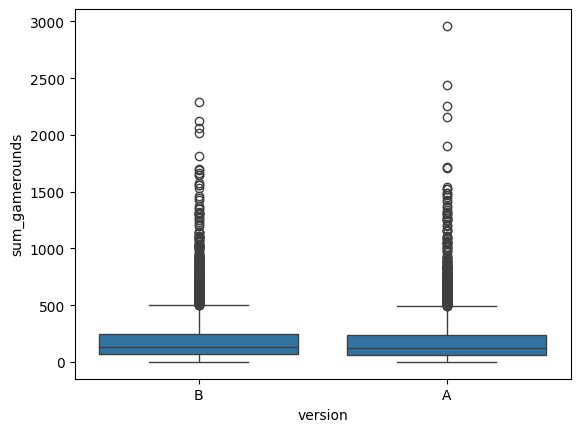

In [179]:
sns.boxplot(x='version',y='sum_gamerounds',data=retention_df)
plt.show()

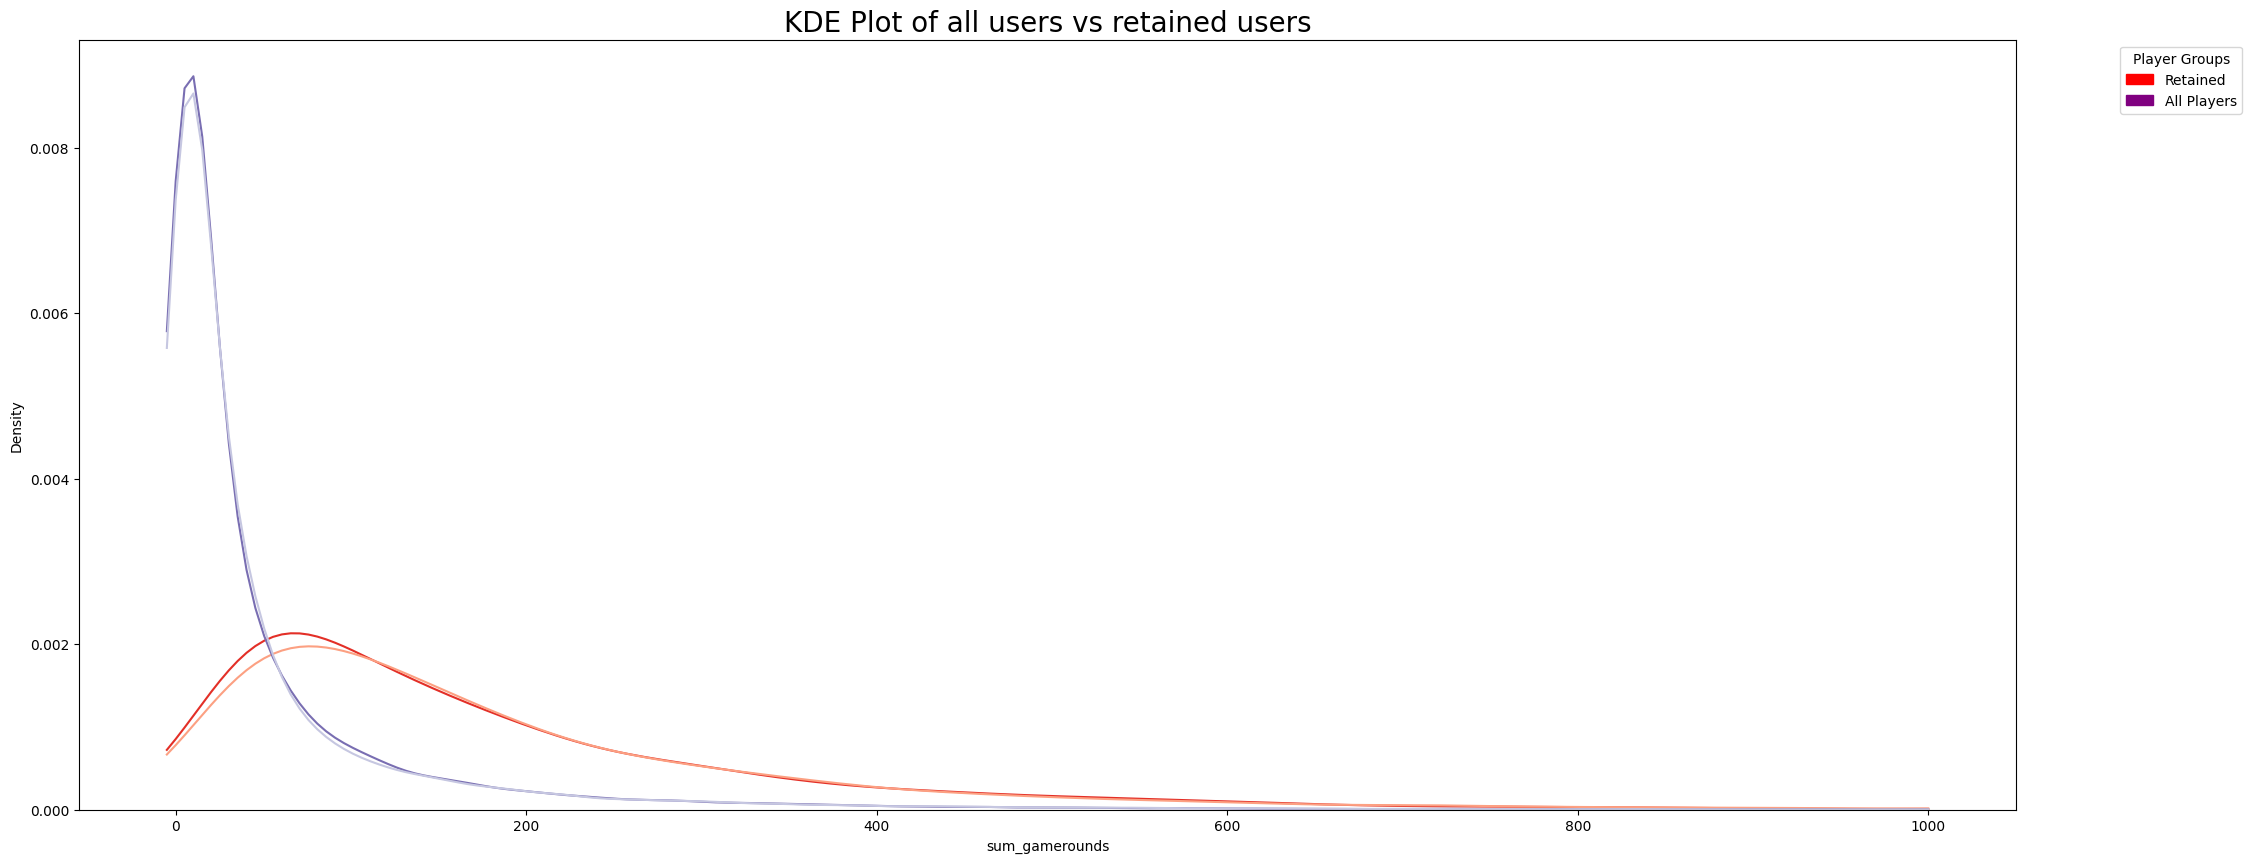

In [180]:
plt.figure(figsize=(25,10))
sns.kdeplot(x='sum_gamerounds',hue='version',data=retention_df, palette='Reds', clip=(-5, 1000))
sns.kdeplot(x='sum_gamerounds',hue='version',data=df, palette='Purples', clip=(-5, 1000))


from matplotlib.patches import Patch
red_patch = Patch(color='red', label='Retained')
purple_patch = Patch(color='purple', label='All Players')
plt.legend(handles=[red_patch, purple_patch], title='Player Groups', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('KDE Plot of all users vs retained users', fontsize=20)
plt.show()

#**INSIGHT**


---




*   When we analysed all the users, there was no statistically significant difference in the number of game-rounds played.


*   But, we observe that the number of game-rounds played by *retained* users vary significantly when the gate is shifted from Gate_30 to Gate_40




# Recommendations



*   The number of users who came back and played the game 1 day after installing but didn't return after 7 days is 30%. *Cookie Cats* team needs to look into the various factors affecting this.


*   Only 14% of the users are retained 7 days after installation. This shows that the game is very attractive to begin with, but isn't as engaging. *Cookie Cats* team need to make the game more engaging in the long term by incorporating real rewards like real money/goodies.

